In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as sqla
import plotly.express as px

In [21]:
DB_NAME = "postgres"
DB_USER = "postgres"
DB_PASS = "a"
DB_HOST = "localhost"
DB_PORT = "5432"

SQL_INIT = "railway.sql"

connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Créer un moteur SQLAlchemy
engine = sqla.create_engine(connection_string)

# Tester la connexion
try:
    with engine.connect() as connection:
        print("Connected to PostgreSQL successfully!")
except Exception as e:
    print(f"Error: {e}")

connection = engine.connect()

Connected to PostgreSQL successfully!


# Import the railway dataset

We import the `lijnsecties.geojson` dataset from infrabel (**link here**) to the database.

In [3]:
SQL_INIT = "railway.sql"

try:
    with open(SQL_INIT, "r") as f:
        query = f.read()
        with engine.connect() as conn:
            conn.execute(sqla.text(query))
        print("The table railway has been created.")
except Exception as e:
    print(e)
    exit()

The table railway has been created.


In [8]:
gdf = gpd.read_file('lijnsecties.geojson')

display(gdf.head())

geo_point_2d  ls_id   label ptcarfrom  \
0  { "lon": 3.5982256714253351, "lat": 50.9881763...    171      75       320   
1  { "lon": 3.9087173889800586, "lat": 50.3351619...    744      96       982   
2  { "lon": 5.7918759444431416, "lat": 49.6858822...    532     162       303   
3  { "lon": 4.3096605191755168, "lat": 51.3028822...   1560  221(1)      1669   
4  { "lon": 3.7420781545790174, "lat": 51.0708085...    188    58/2       456   

  ptcarfromname ptcarto  ptcartoname   mfrom     mto     ecs_voltfreq  ...  \
0      DE PINTE      93  DEINZE-WIJK    7200   13966           3kV DC  ...   
1         QUEVY     983     QUEVY-FR   74800   76218          25kV AC  ...   
2  STOCKEM-BL95      70        ARLON  194961  198000          25kV AC  ...   
3       Y.BAYER    1675  Y.LILLOBRUG   12855   13632  Not Electrified  ...   
4     GENT-ZEEH     172      Y.MUIDE    7485    8945  Not Electrified  ...   

   ecs_maxstandstillcurrent  ecs_minwireheight  nrtracks  c400 c70 p70 p400  \
0                     200.0                4.8         2   400  70  70  400   
1                       NaN                4.8         2   400  70  70  400   
2                       NaN                5.0         2   400  70  70  400   
3                       NaN                NaN         2   400  70  70  400   
4                       NaN                NaN         1   400  70  70  400   

  symnamefrom symnameto                                           geometry  
0         FPT      FDWS  LINESTRING (3.65538 50.99895, 3.65373 50.99825...  
1         LQV     LQVFR  LINESTRING (3.90964 50.34149, 3.9095 50.34056,...  
2       MKMSD        LL  LINESTRING (5.77273 49.69031, 5.78547 49.68828...  
3       YBYER     YLIBR  LINESTRING (4.30862 51.30107, 4.30862 51.30136...  
4        FGZH     YMUDE  LINESTRING (3.74266 51.06598, 3.74347 51.06787...  

[5 rows x 21 columns]

We will keep the columns : `geometry` (i.e., the column that contains the geopoints of lines), `label` (i.e., the name/number of the line), and `ptcarfrom` (we don't have idea of the meaning of this column, it is not explained in the source but we keep it by security it may be useful..)

In [9]:
cols_to_keep = ["label", "geometry", "ptcarfrom"]
gdf = gdf[cols_to_keep]
mapping = {"geometry": "geom", "label": "line_number", "ptcarfrom": "ptcarfrom"}
gdf = gdf.rename(columns=mapping)

gdf = gdf.set_geometry("geom")
gdf.to_postgis("railway", engine, if_exists='replace', index=False)

# Exploratory Data Analysis on map

## Percentage of delay depending of the line used by trains

In [22]:
Query = """
WITH count_delay AS (
    SELECT
        line_number_departure,
        COUNT(*) as TOTAL_COUNT,
        SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) AS delayed_count,
        (SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS delay_percentage
    FROM
        train_data
    GROUP BY
        line_number_departure
)
SELECT
    cd.line_number_departure,
    cd.delay_percentage,
    r.geom
FROM
    count_delay cd
JOIN
    railway r ON cd.line_number_departure = r.line_number
"""



delay_percentage = gpd.read_postgis(sqla.text(Query), connection)

delay_percentage

ObjectNotExecutableError: Not an executable object: 'SELECT srid, auth_name FROM spatial_ref_sys WHERE srid = 4326'

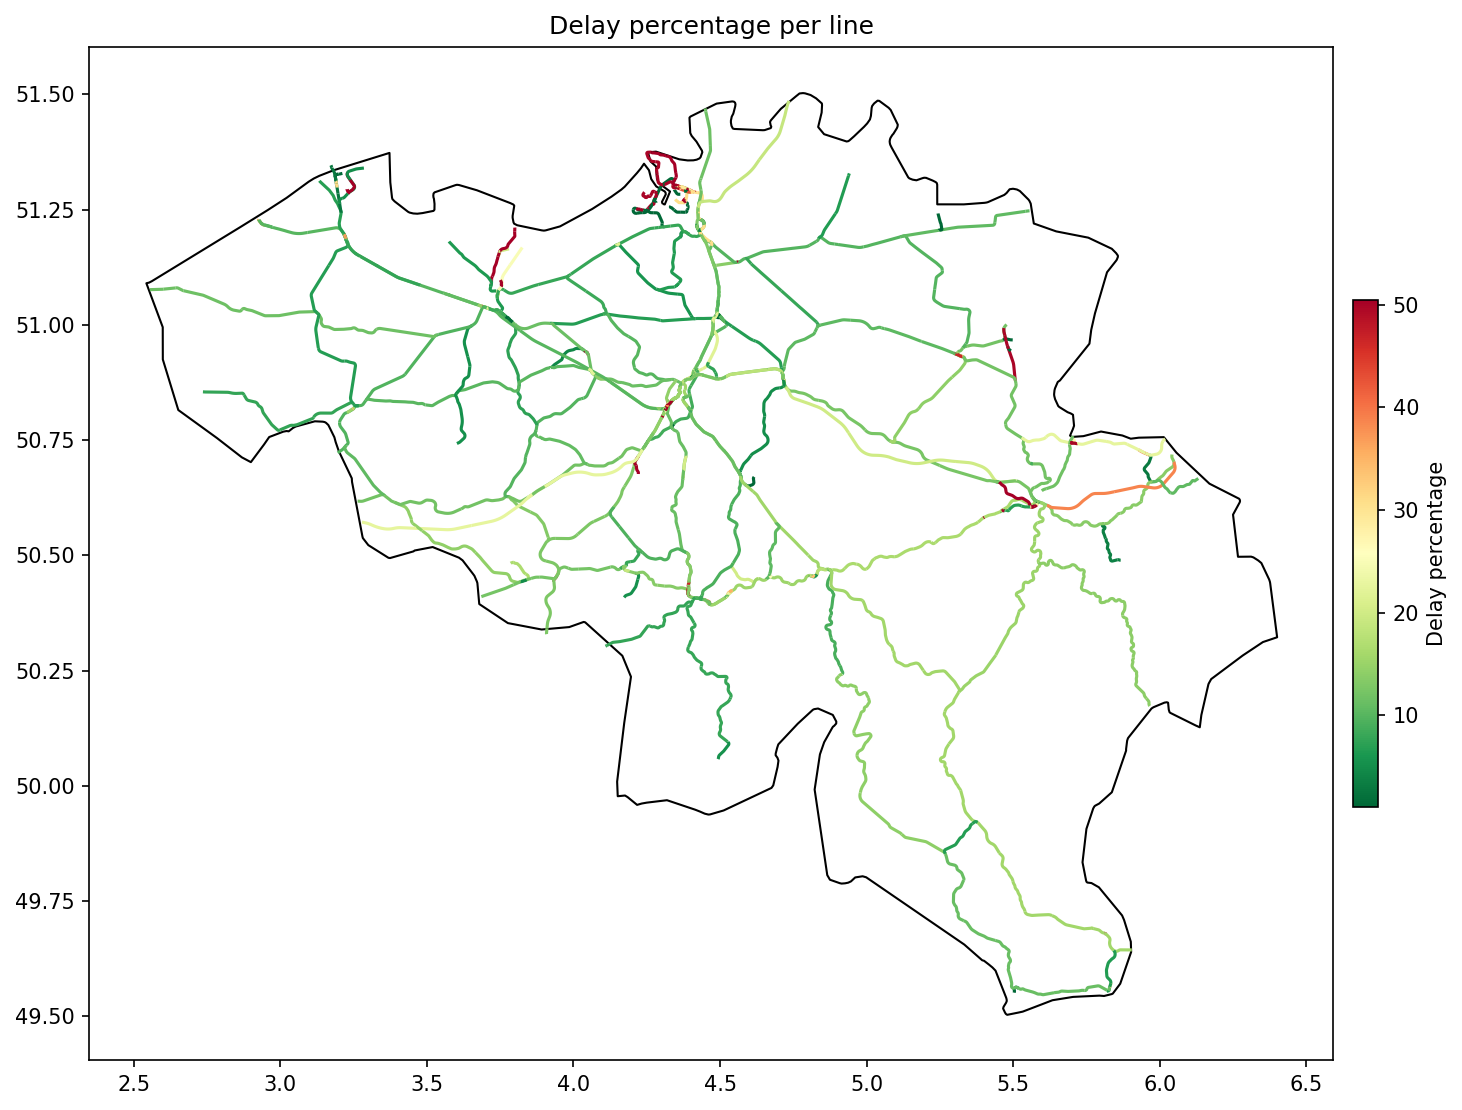

In [8]:
from matplotlib.colors import Normalize

url = "https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson"
europe = gpd.read_file(url)

# Filter for Belgium
belgium = europe[europe['NAME'] == 'Belgium']

# plot heatmap of delay percentage per line number on the map
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
vmin, vmax = delay_percentage['delay_percentage'].quantile(0.05), delay_percentage['delay_percentage'].quantile(0.95)
norm = Normalize(vmin=vmin, vmax=vmax)
delay_percentage.plot(ax=ax, column='delay_percentage', legend=True, cmap='RdYlGn_r',     legend_kwds={
        'label': "Delay percentage",
        'shrink': 0.5,   # Reduce the size of the legend bar
        'aspect': 20,     # Make the legend bar thinner
        'pad': 0.01       # Reduce gap between plot and legend
    }, vmin=vmin, vmax=vmax)
belgium.plot(ax=ax, edgecolor='black', facecolor="white", linewidth=1)
plt.title("Delay percentage per line")
plt.tight_layout()
plt.show()

# Percentage of delayed trains at stations

In [9]:
Query = """
WITH DelayedCounts AS (
    SELECT
        ptcar_name AS station_id,
        COUNT(*) AS total_count,
        SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) AS delayed_count,
        (SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS delay_percentage
    FROM TRAIN_DATA
    GROUP BY ptcar_name
    HAVING COUNT(*) >= 100
)
SELECT 
    s.id, 
    s.name,
	s.geom,
    dc.total_count, 
    dc.delayed_count, 
    dc.delay_percentage
FROM DelayedCounts dc
JOIN STATIONS s ON dc.station_id = s.id
ORDER BY dc.delay_percentage DESC;
"""

delayed_stations = gpd.read_postgis(Query, engine)

delayed_stations

id                          name                      geom  total_count  \
0    764  VORST-RIJTUIGEN-DIENSTPERRON  POINT (4.31464 50.81765)          848   
1    337                HASSELT-L.C.I.   POINT (5.30975 50.9369)          371   
2    585             OOSTENDE-BUNDEL B  POINT (2.93927 51.21781)          167   
3    537             MONCEAU-RECEPTION  POINT (4.39166 50.43599)          104   
4    767     VORST-ZUID-SPOREN 920/926  POINT (4.31084 50.81102)         1487   
..   ...                           ...                       ...          ...   
713  635                         RONSE  POINT (3.60261 50.74237)       131960   
714  701                SPA-GERONSTERE  POINT (5.86623 50.48928)       119413   
715  800                ZEEBRUGGE-DORP  POINT (3.19684 51.32659)        72246   
716  814                  Zwankendamme  POINT (3.19694 51.31001)        30974   
717  801              ZEEBRUGGE-STRAND   POINT (3.1864 51.32448)        35051   

     delayed_count  delay_percentage  
0              591         69.693396  
1              244         65.768194  
2              108         64.670659  
3               62         59.615385  
4              723         48.621385  
..             ...               ...  
713           3791          2.872840  
714           3249          2.720809  
715           1940          2.685270  
716            696          2.247046  
717            598          1.706085  

[718 rows x 6 columns]

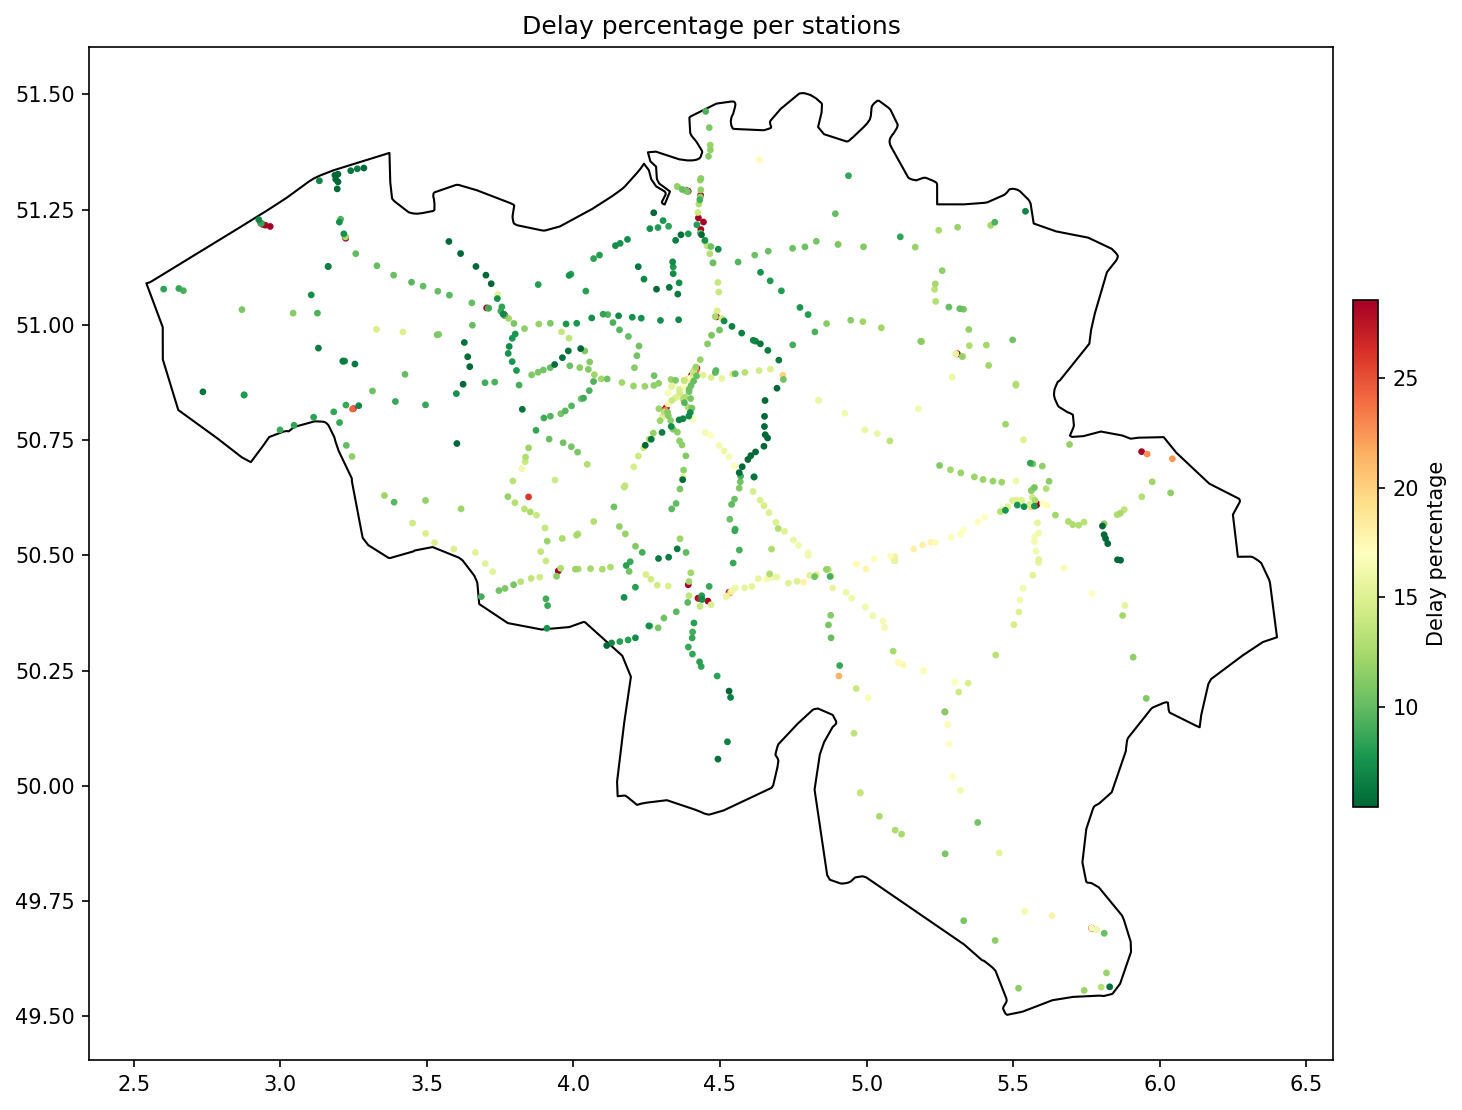

In [10]:
url = "https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson"
europe = gpd.read_file(url)

# Filter for Belgium
belgium = europe[europe['NAME'] == 'Belgium']

fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
vmin, vmax = delayed_stations['delay_percentage'].quantile(0.05), delayed_stations['delay_percentage'].quantile(0.95)
norm = Normalize(vmin=vmin, vmax=vmax)
belgium.plot(ax=ax, edgecolor='black', facecolor="white", linewidth=1)
delayed_stations.plot(ax=ax, column='delay_percentage', legend=True, cmap='RdYlGn_r',     legend_kwds={
        'label': "Delay percentage",
        'shrink': 0.5,   # Reduce the size of the legend bar
        'aspect': 20,     # Make the legend bar thinner
        'pad': 0.01       # Reduce gap between plot and legend
    }, vmin=vmin, vmax=vmax, markersize=5)
plt.title("Delay percentage per stations")
plt.tight_layout()
plt.show()

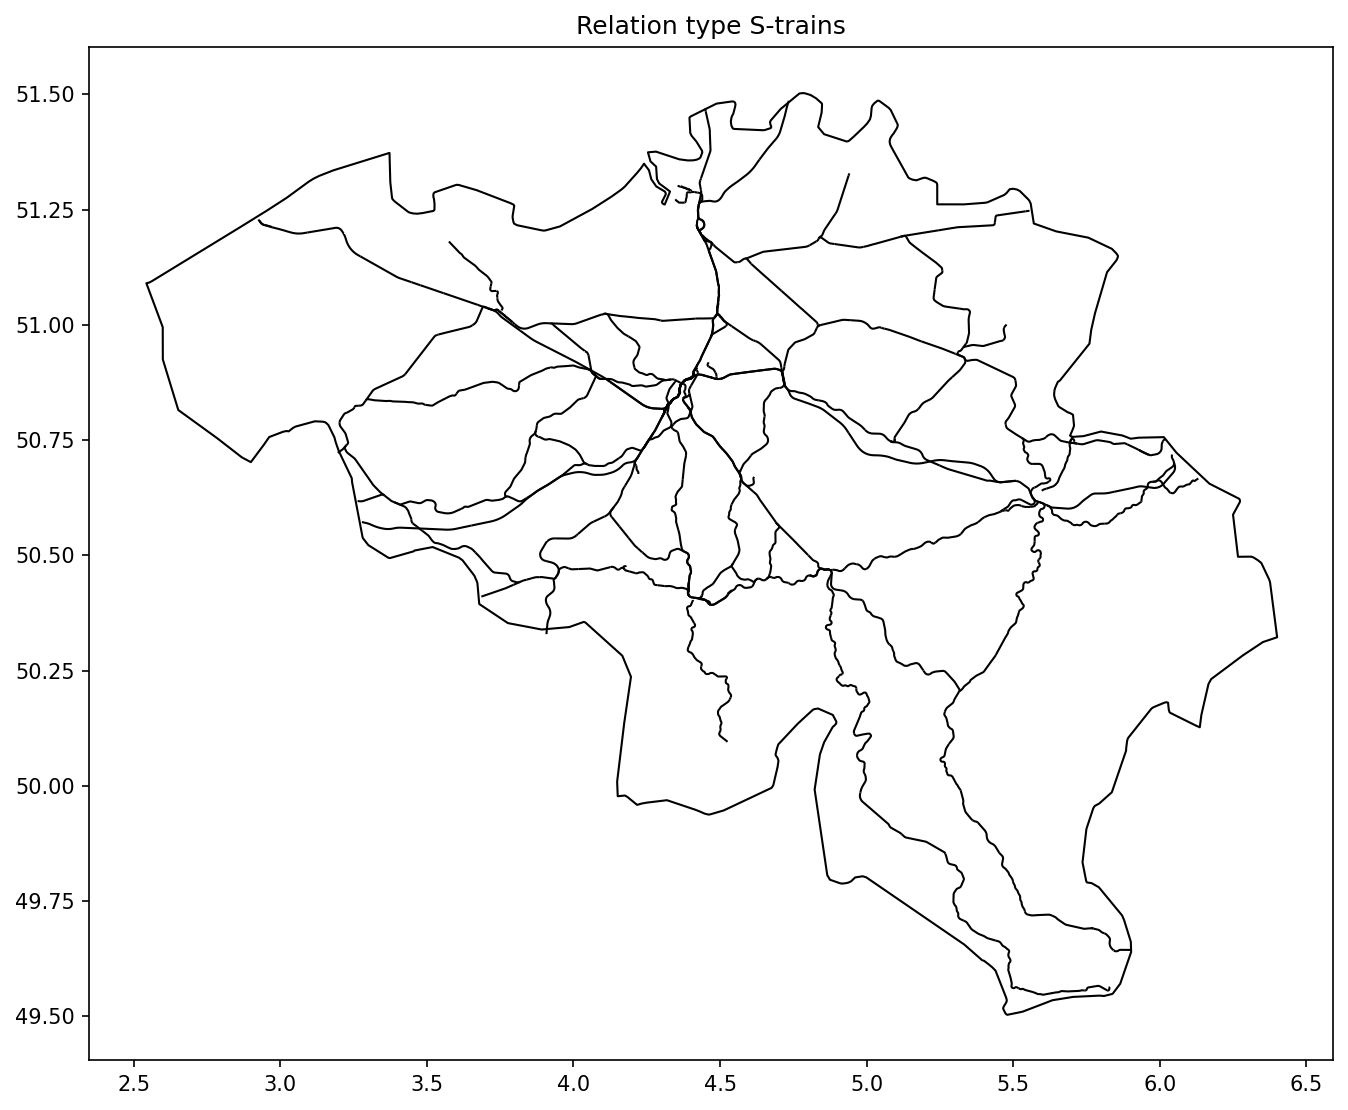

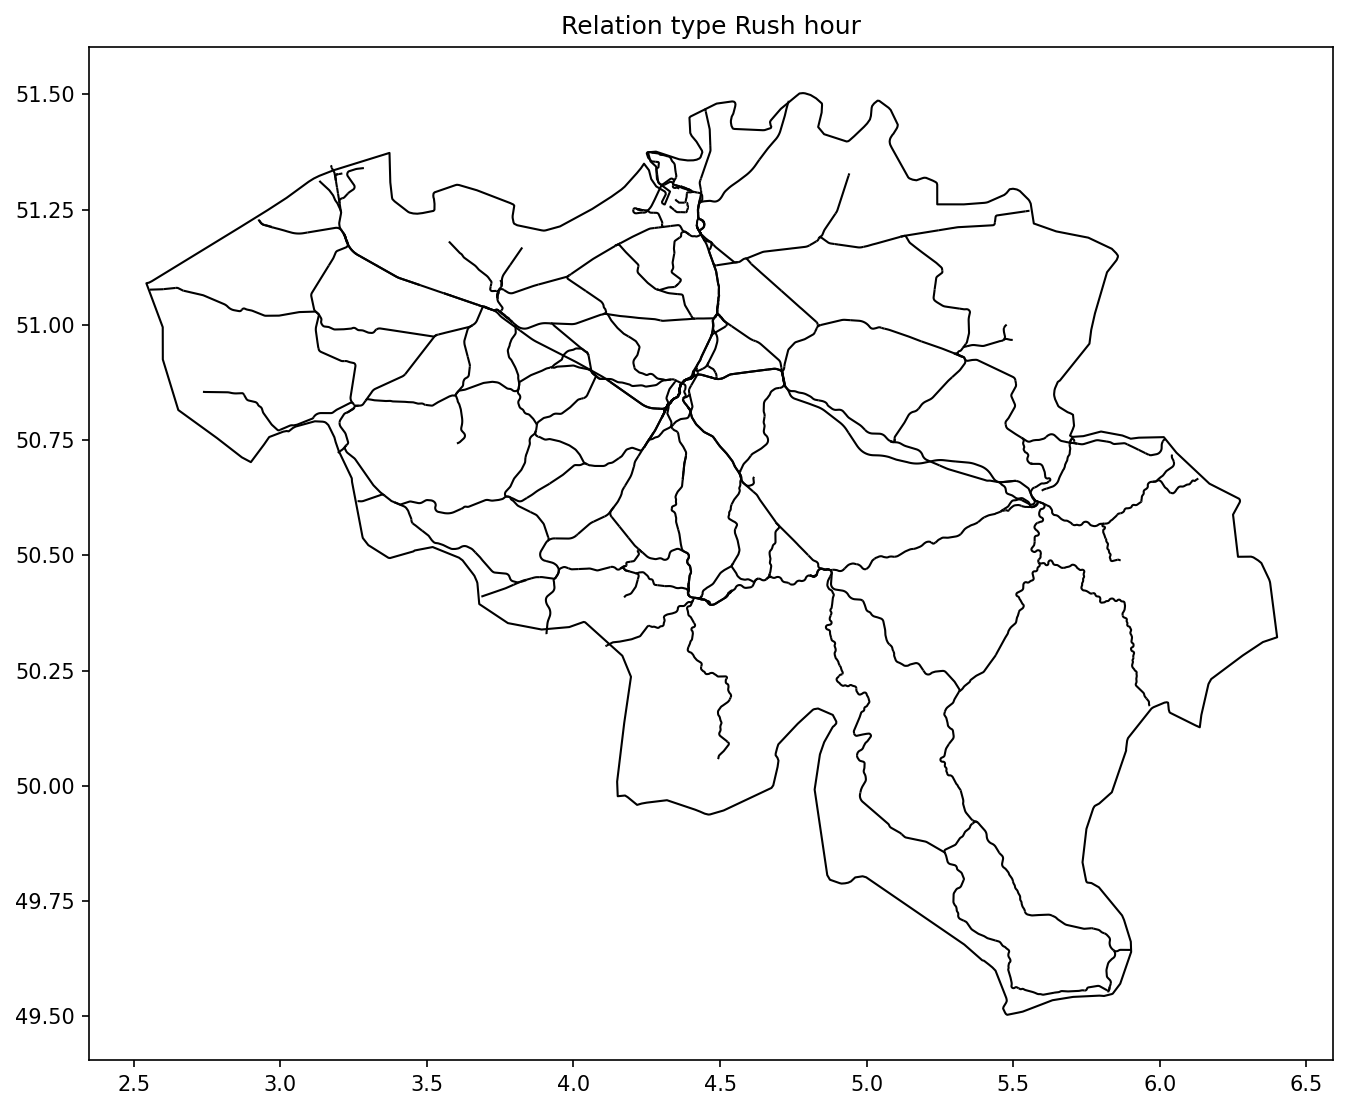

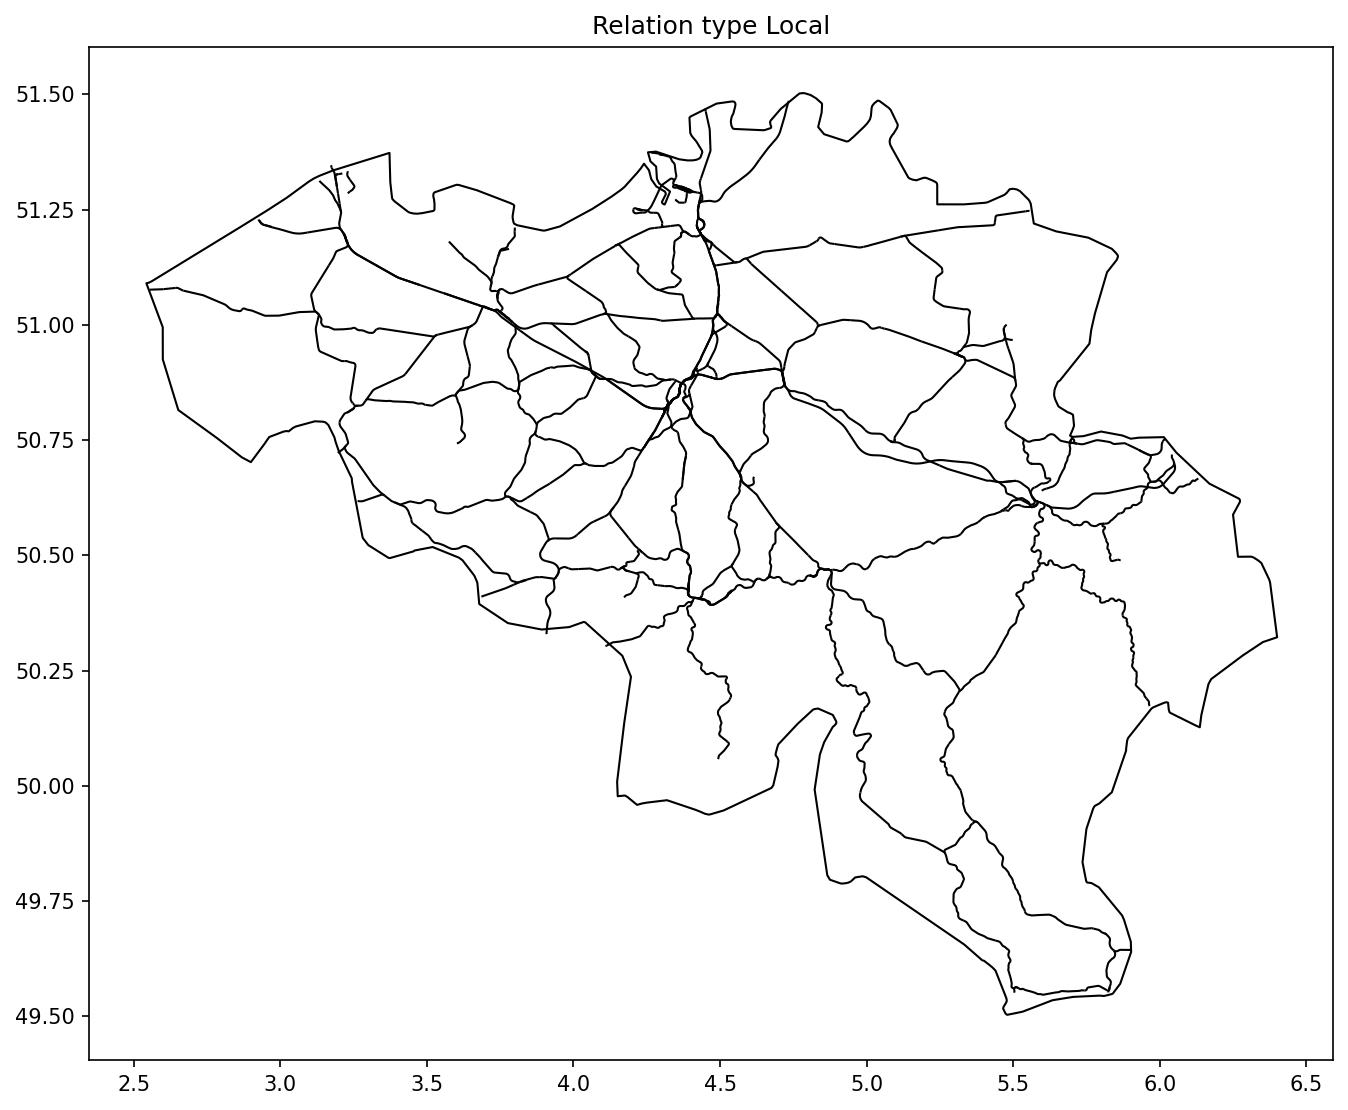

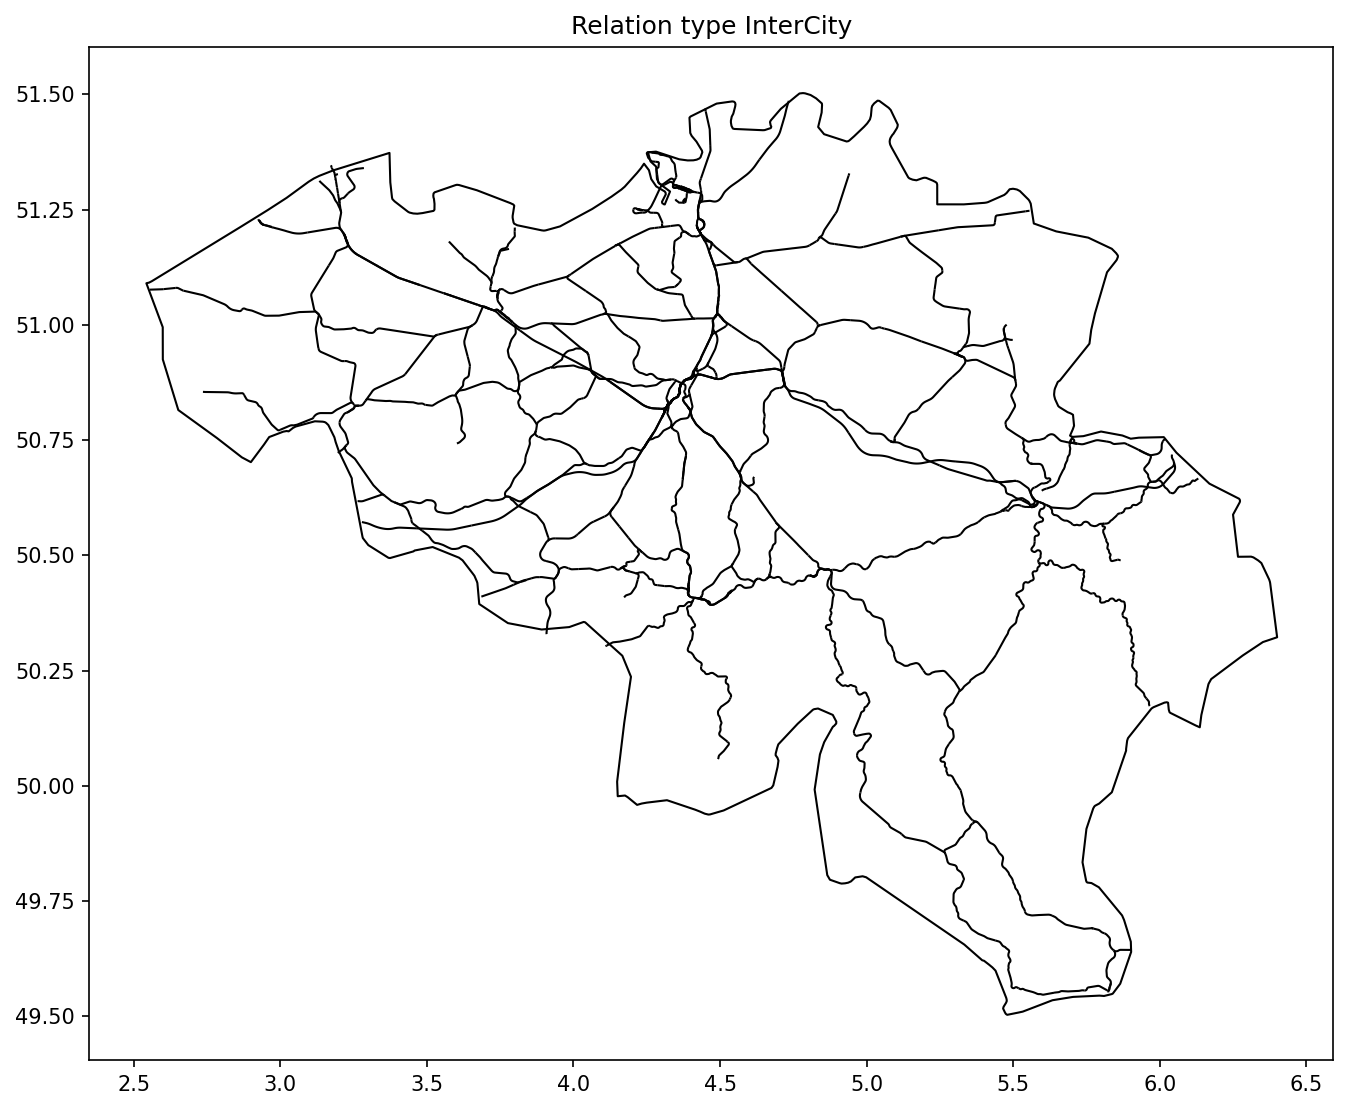

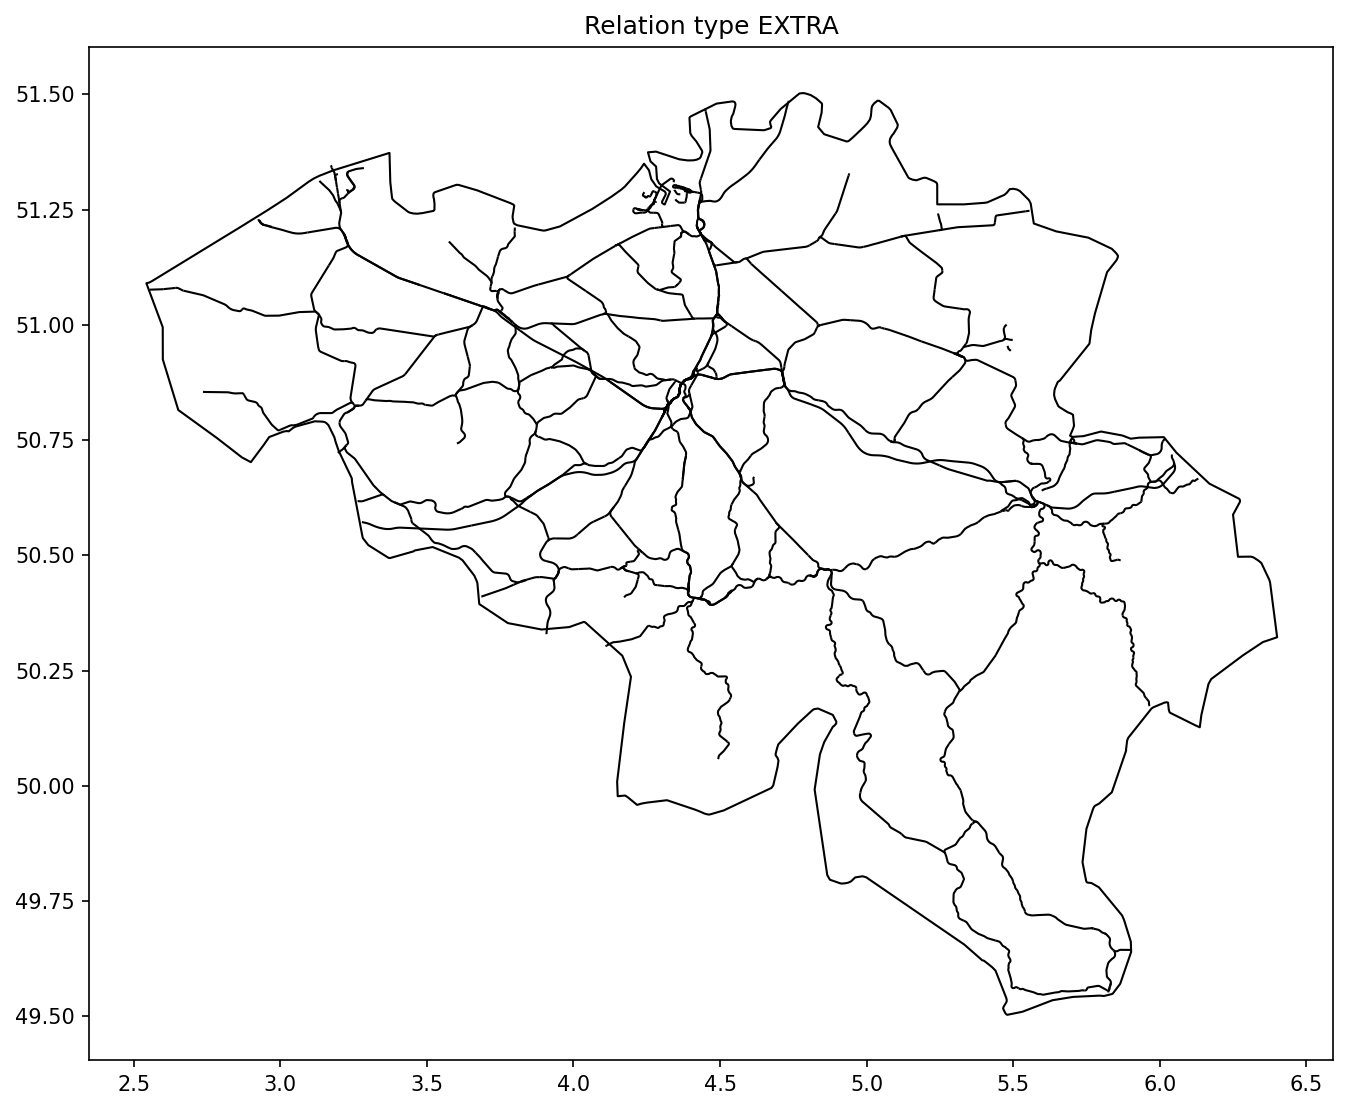

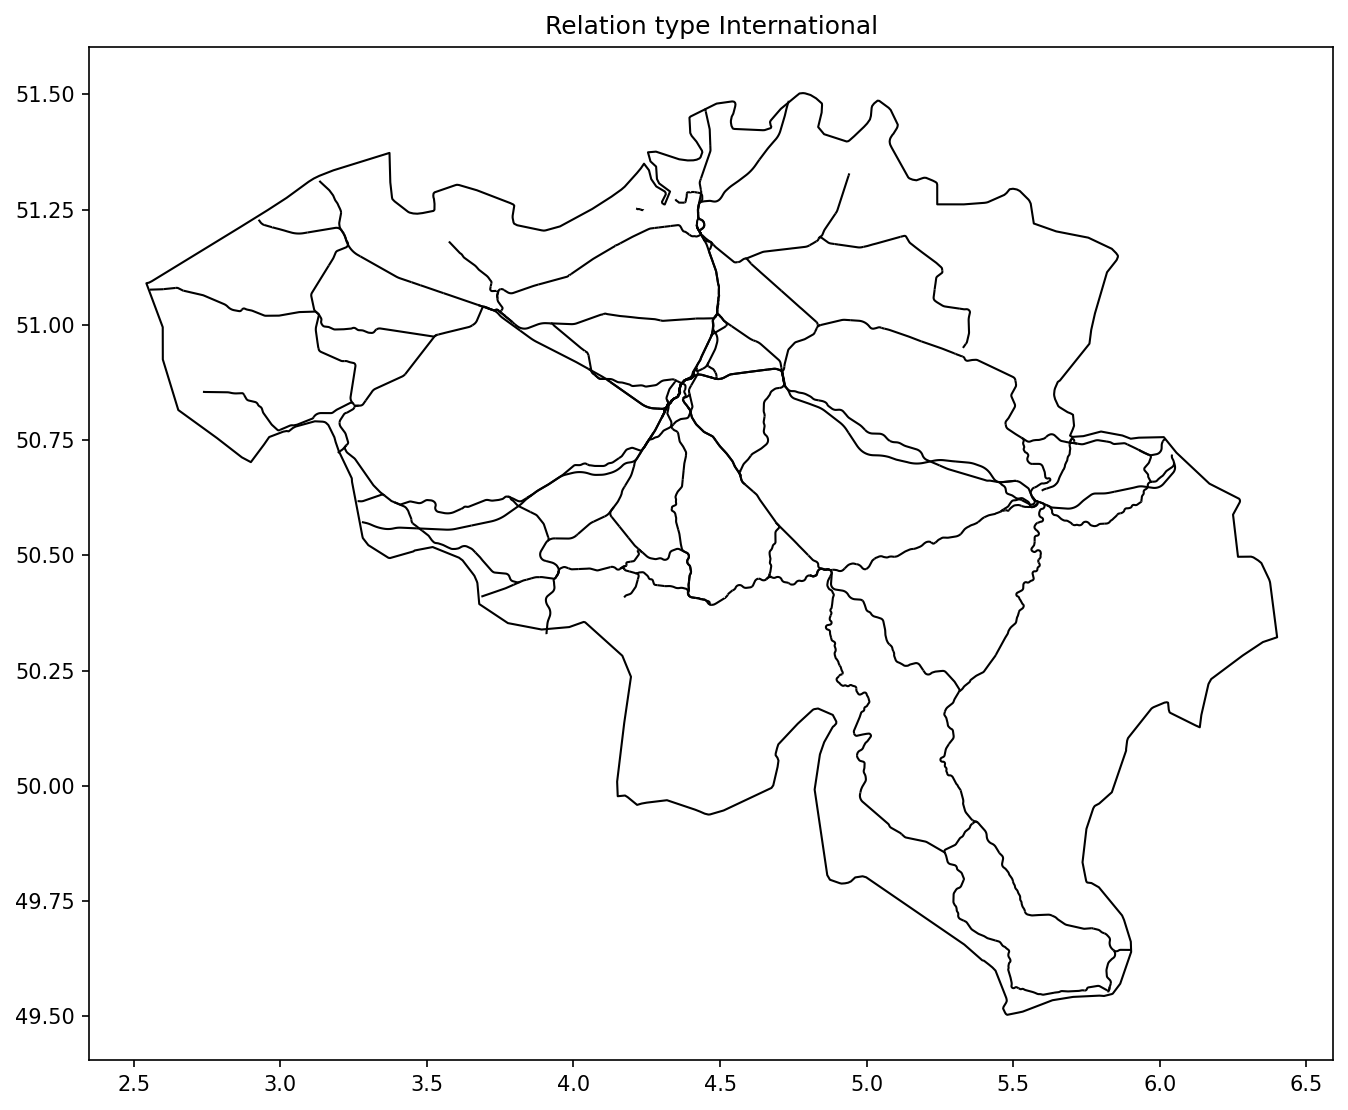

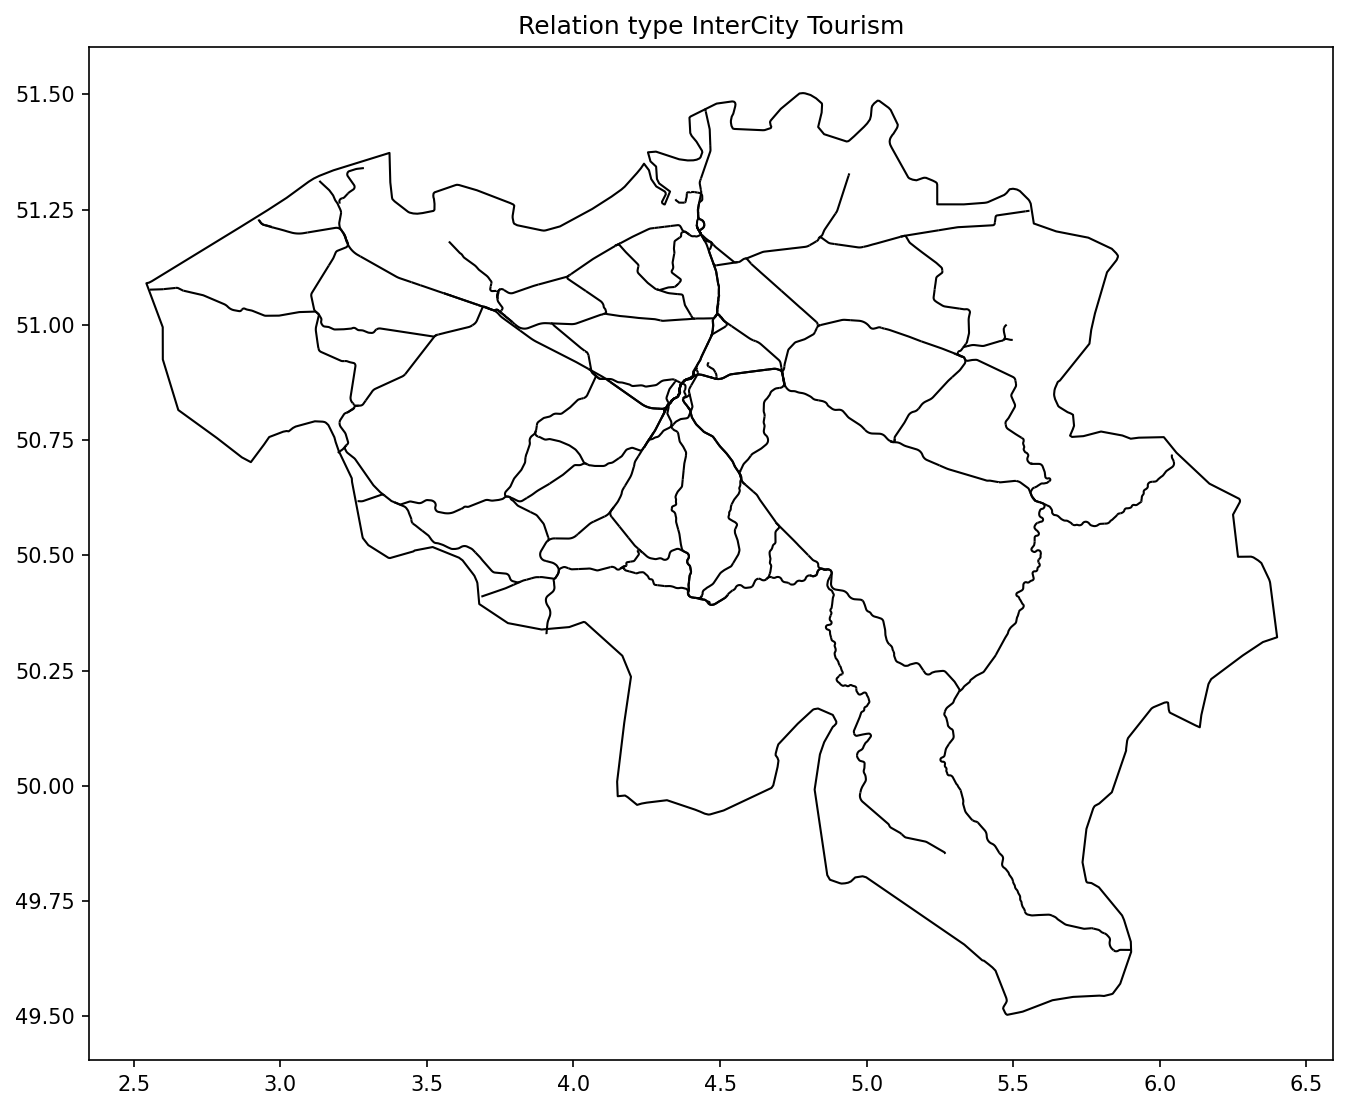

In [11]:
type_map = {
    0: "Cannot be determined",
    1: "S-trains",
    2: "Rush hour",
    3: "Local",
    4: "InterCity",
    5: "EXTRA",
    6: "International",
    7: "InterCity Tourism"
	}


url = "https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson"
europe = gpd.read_file(url)

# Filter for Belgium
belgium = europe[europe['NAME'] == 'Belgium']

for i in range(1, 8):
	QUERY = f"""
	WITH lines AS (
		SELECT DISTINCT
			td.line_number_departure
		FROM
			train_data td
		JOIN
			relation rel on rel.id = td.relation
		WHERE
			rel.type = '{i}'    
			AND td.line_number_departure is not null
	)
	SELECT DISTINCT
		l.line_number_departure ,
		r.geom
	FROM
		lines l
	JOIN
		railway r on r.line_number = l.line_number_departure
	"""

	line_relation = gpd.read_postgis(QUERY, engine)

	fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
	line_relation.plot(ax=ax, color='black', linewidth=1)
	belgium.plot(ax=ax, edgecolor='black', facecolor="white", linewidth=1)
	plt.title(f"Relation type {type_map[i]}")
	plt.tight_layout()
	plt.show()


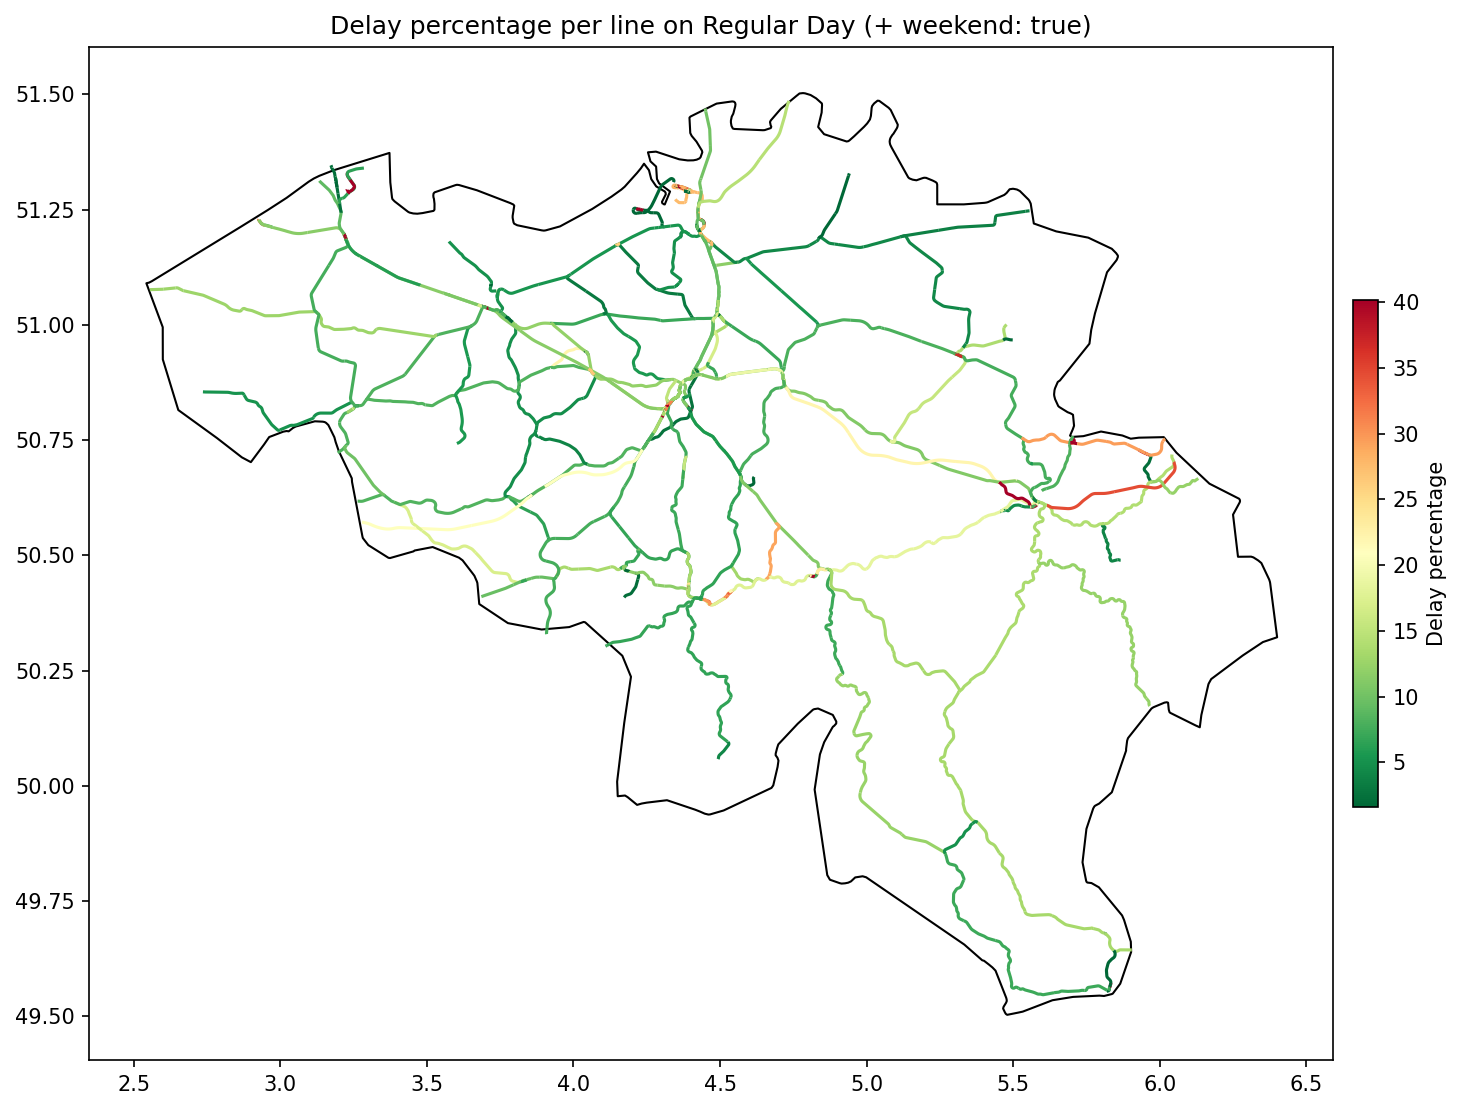

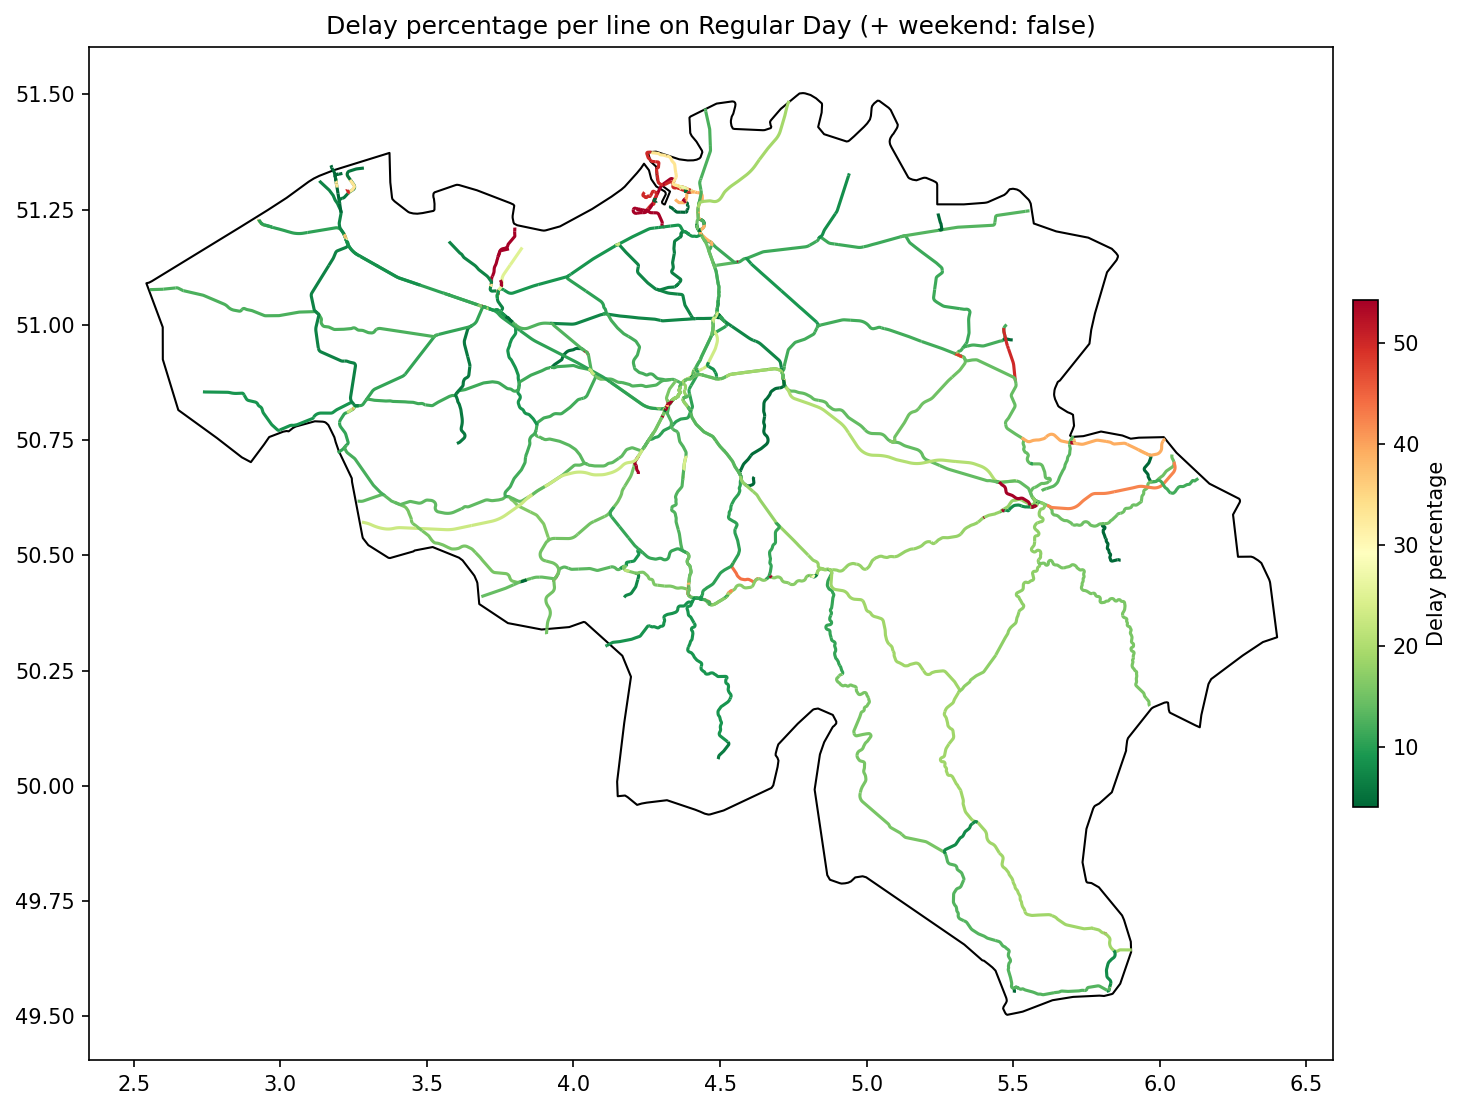

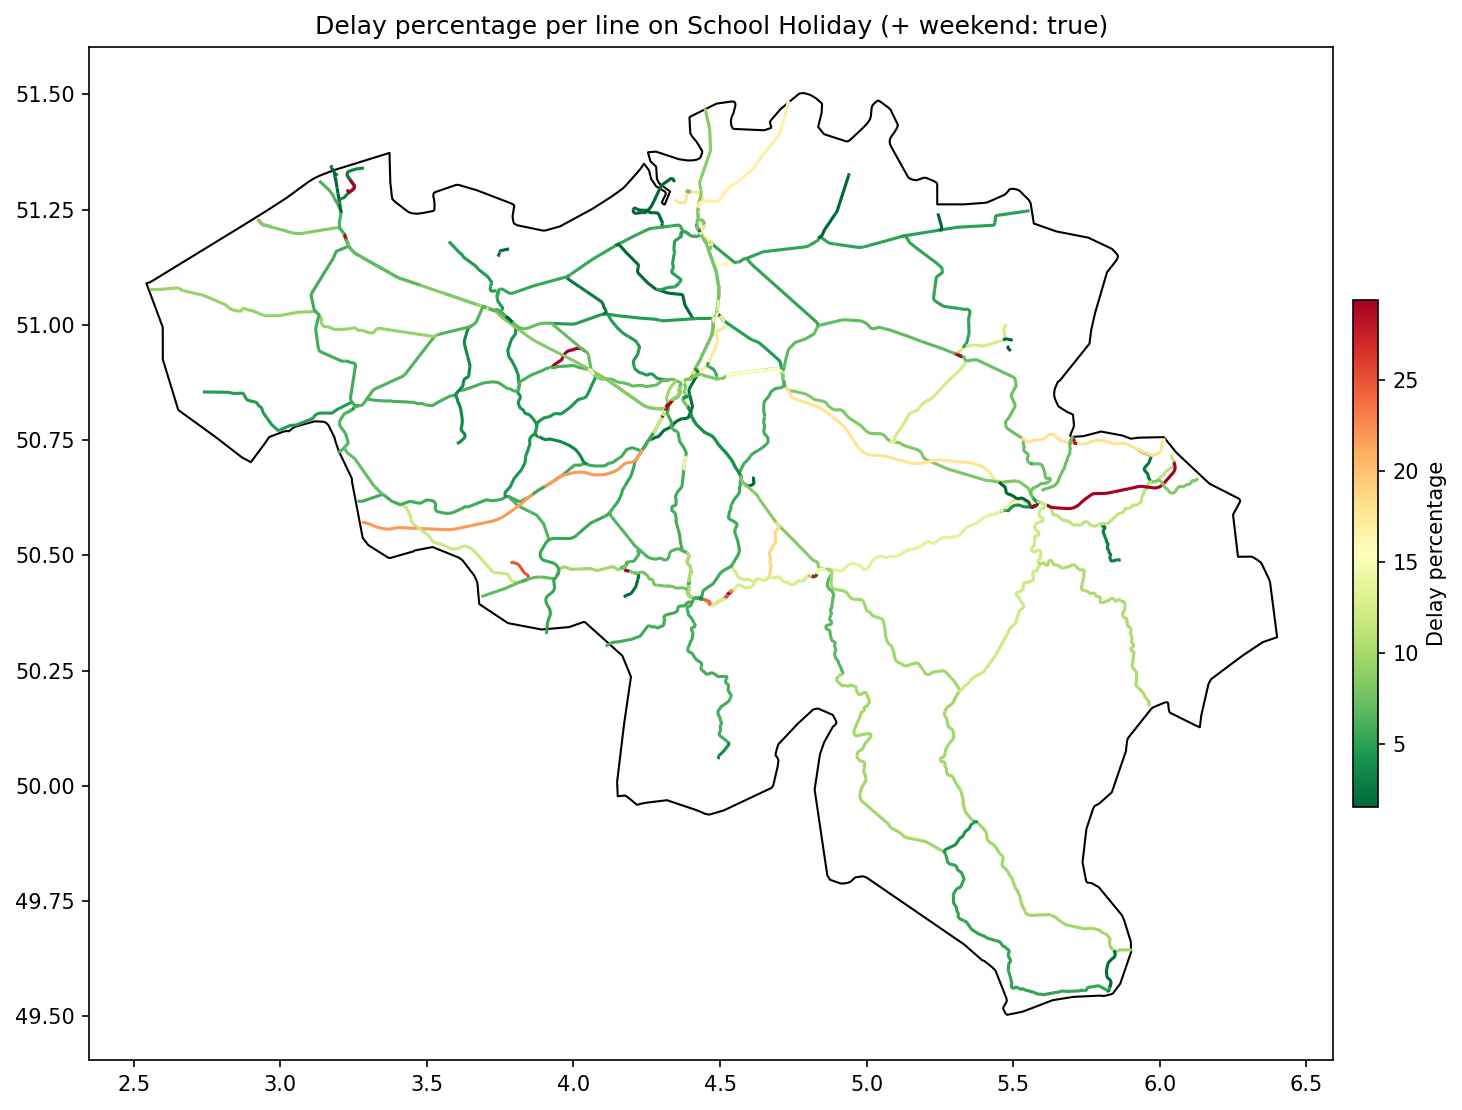

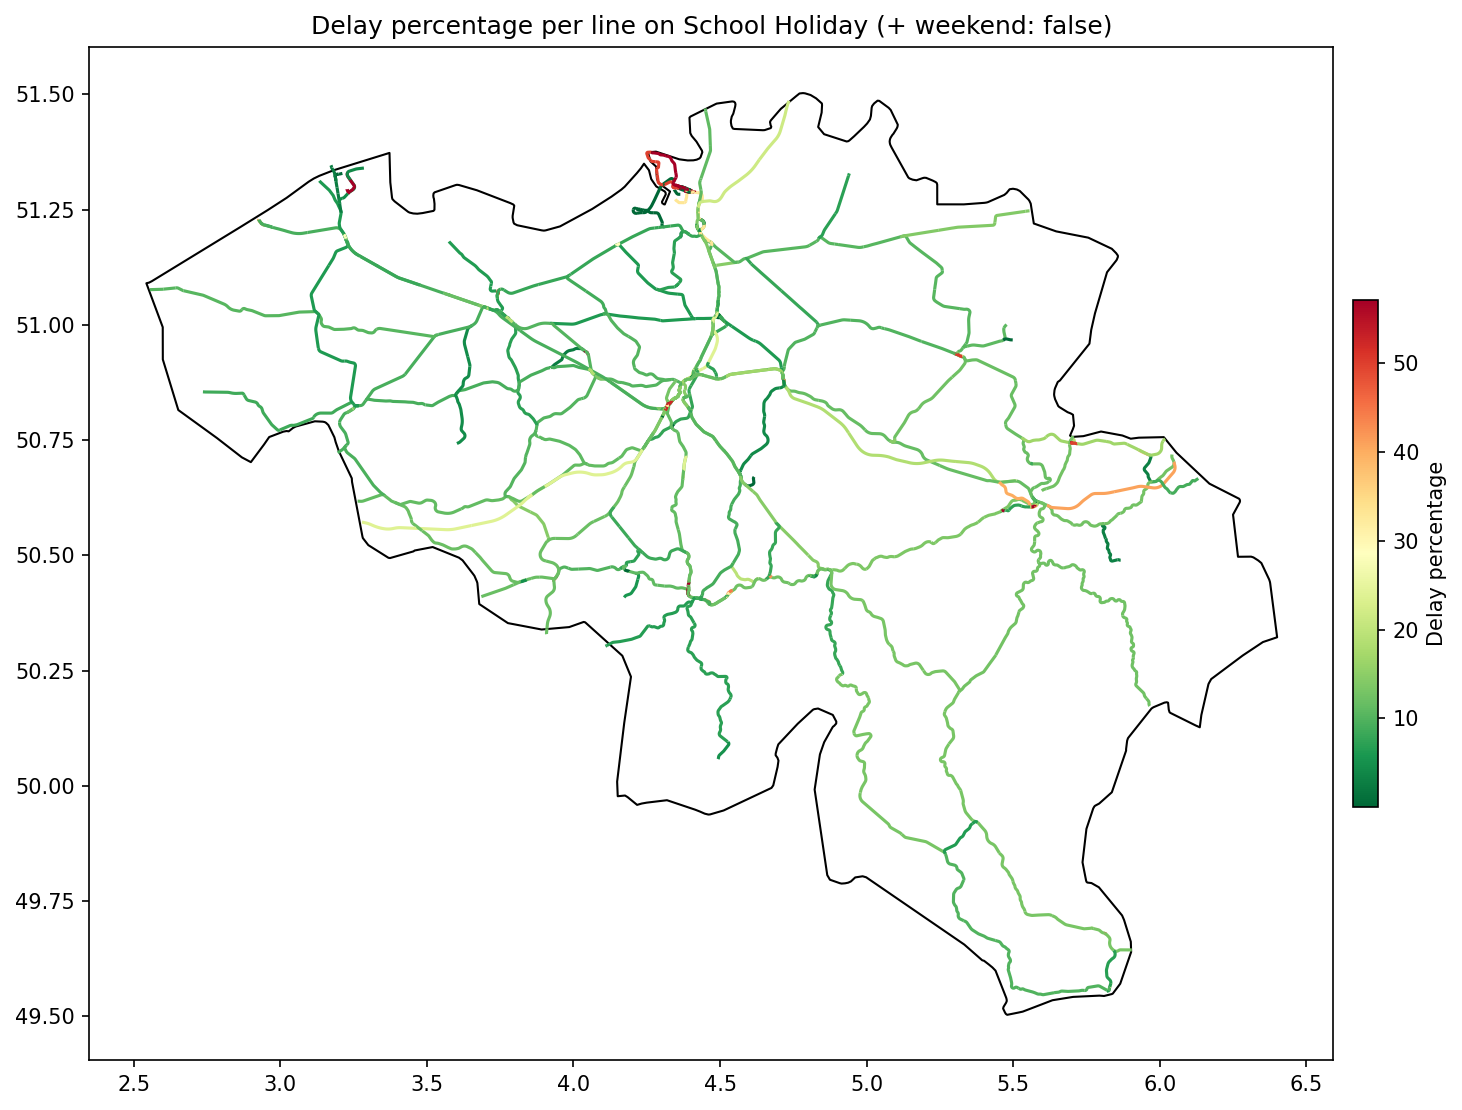

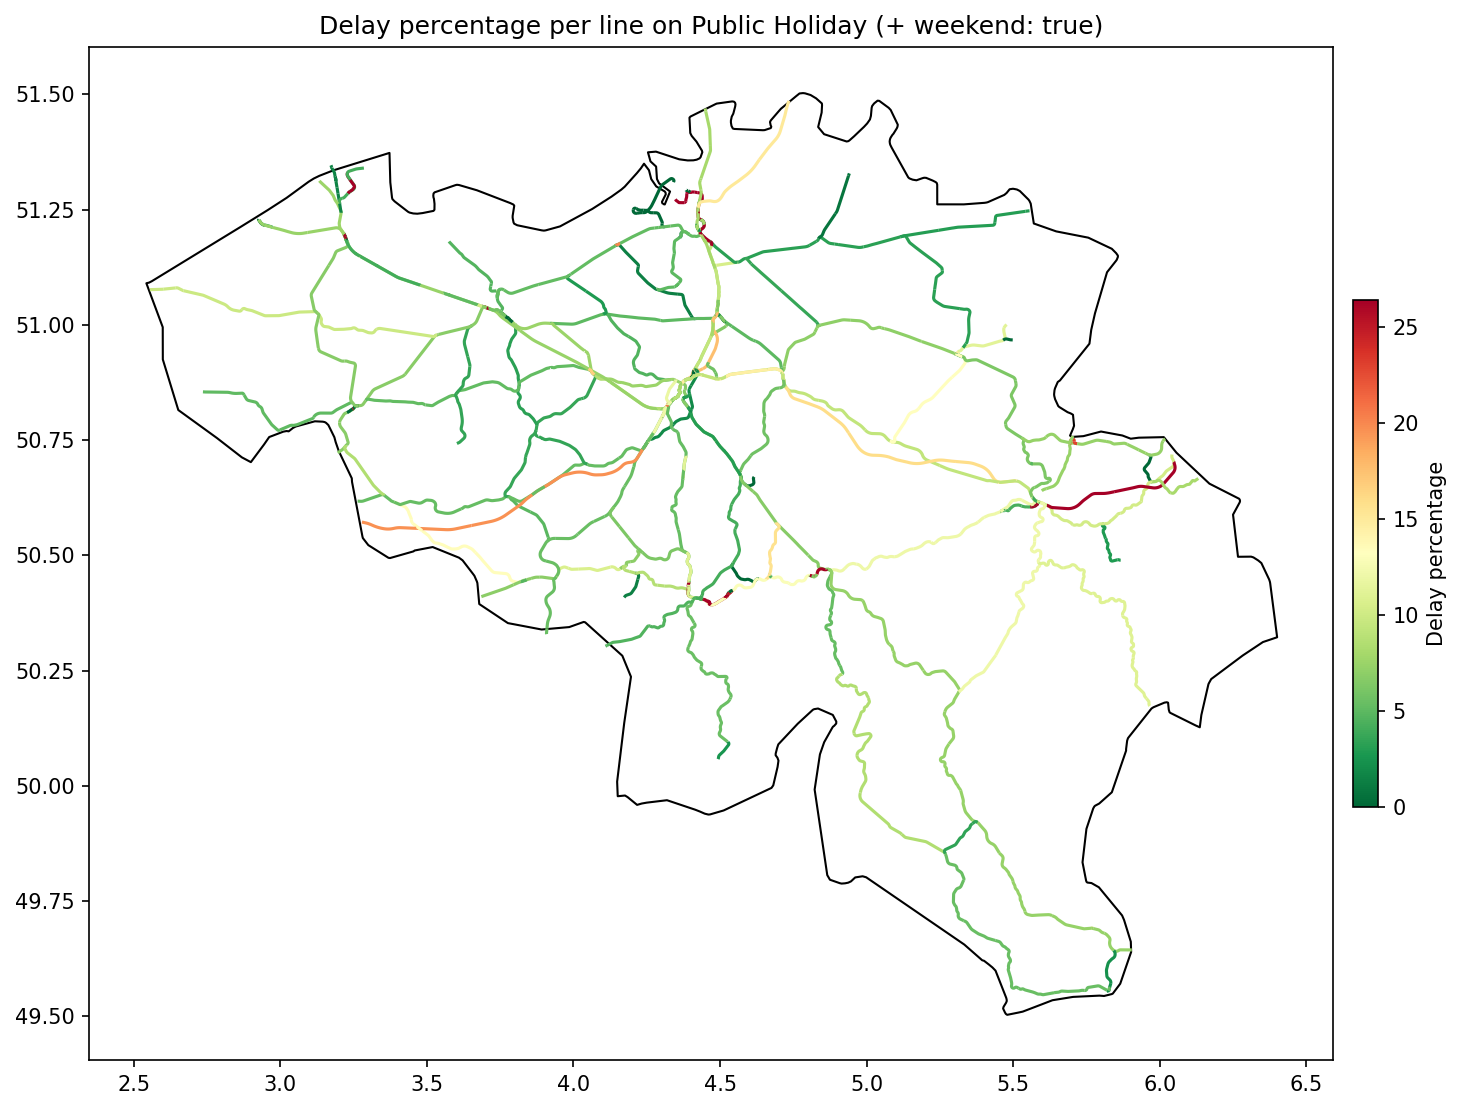

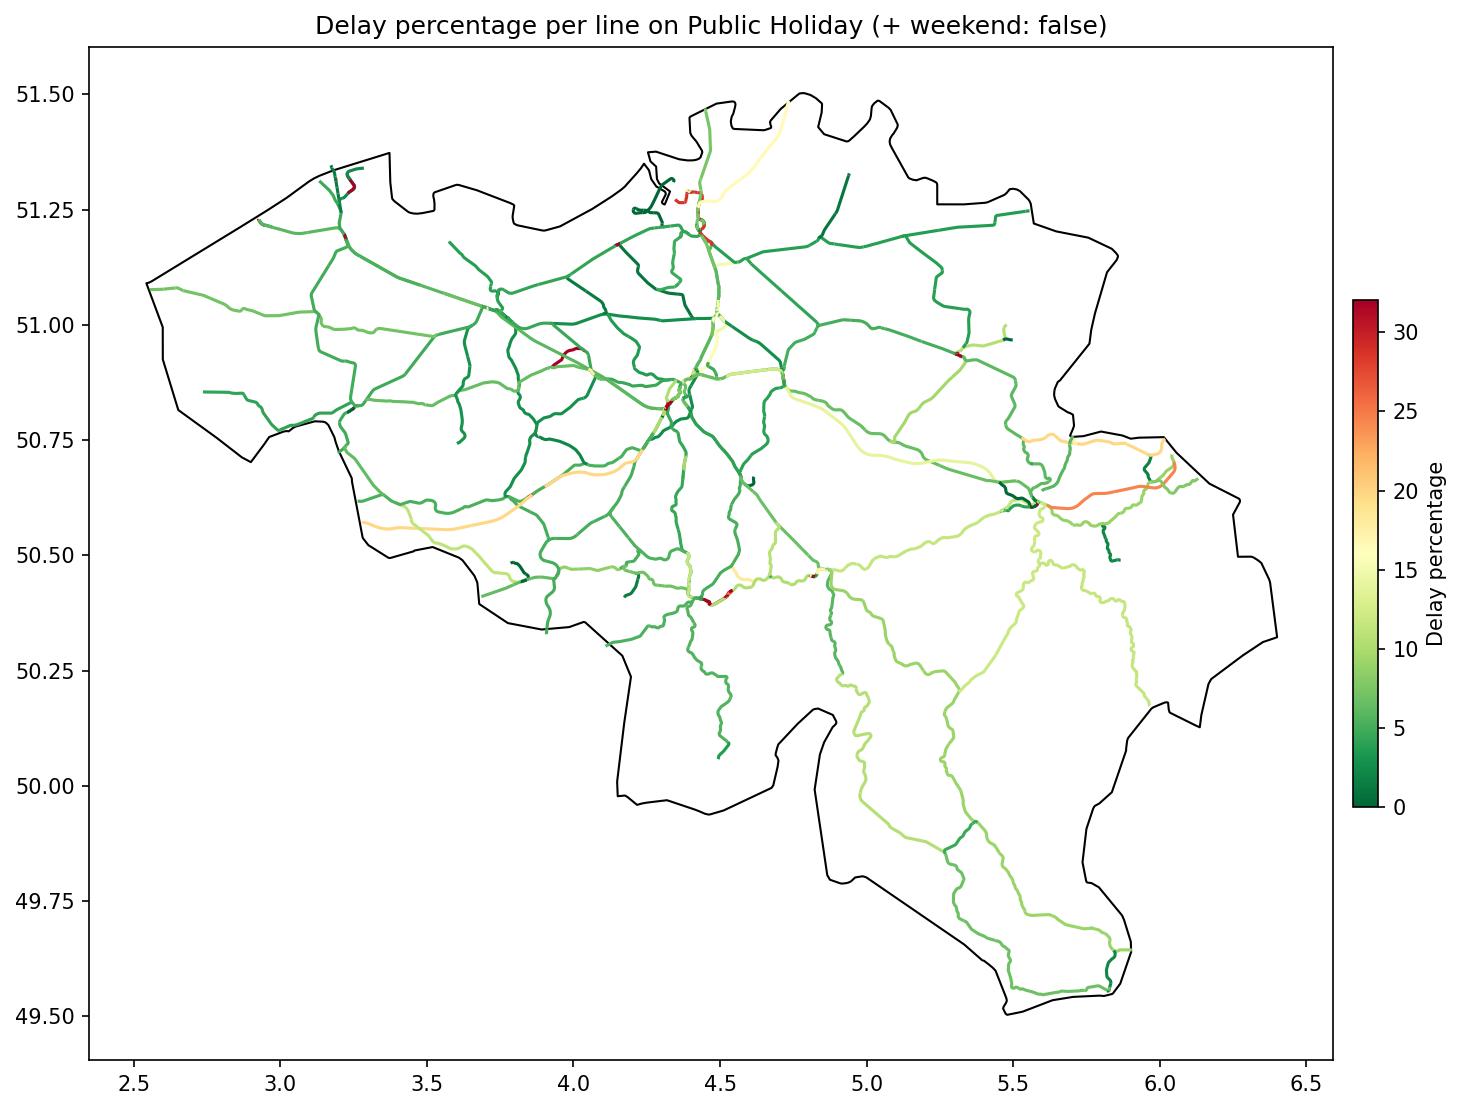

In [12]:
type_day_map = {
    0: "Regular Day",
    1: "School Holiday",
    2: "Public Holiday"
}

for i in range(0, 3):
    for v in ["true", "false"]:
        query = f"""
        WITH delay_counts AS (
            SELECT
                line_number_departure,
                COUNT(*) as TOTAL_COUNT,
                SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) AS delayed_count,
                (SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS delay_percentage
            FROM
                train_data td
            JOIN
                type_day h on h.date = td.departure_date
            WHERE
                h.holiday = '{i}'
                AND h.weekend = {v}
            GROUP BY
                line_number_departure
        )
        SELECT
            cd.line_number_departure,
            cd.delay_percentage,
            r.geom
        FROM
            delay_counts cd
        JOIN
            railway r ON cd.line_number_departure = r.line_number
        """

        delay_percentage = gpd.read_postgis(query, engine)

        fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
        vmin, vmax = delay_percentage['delay_percentage'].quantile(0.05), delay_percentage['delay_percentage'].quantile(0.95)
        norm = Normalize(vmin=vmin, vmax=vmax)
        delay_percentage.plot(ax=ax, column='delay_percentage', legend=True, cmap='RdYlGn_r',     legend_kwds={
                'label': "Delay percentage",
                'shrink': 0.5,   # Reduce the size of the legend bar
                'aspect': 20,     # Make the legend bar thinner
                'pad': 0.01       # Reduce gap between plot and legend
            }, vmin=vmin, vmax=vmax)
        belgium.plot(ax=ax, edgecolor='black', facecolor="white", linewidth=1)
        plt.title(f"Delay percentage per line on {type_day_map[i]} (+ weekend: {v})")
        plt.tight_layout()
        plt.show()

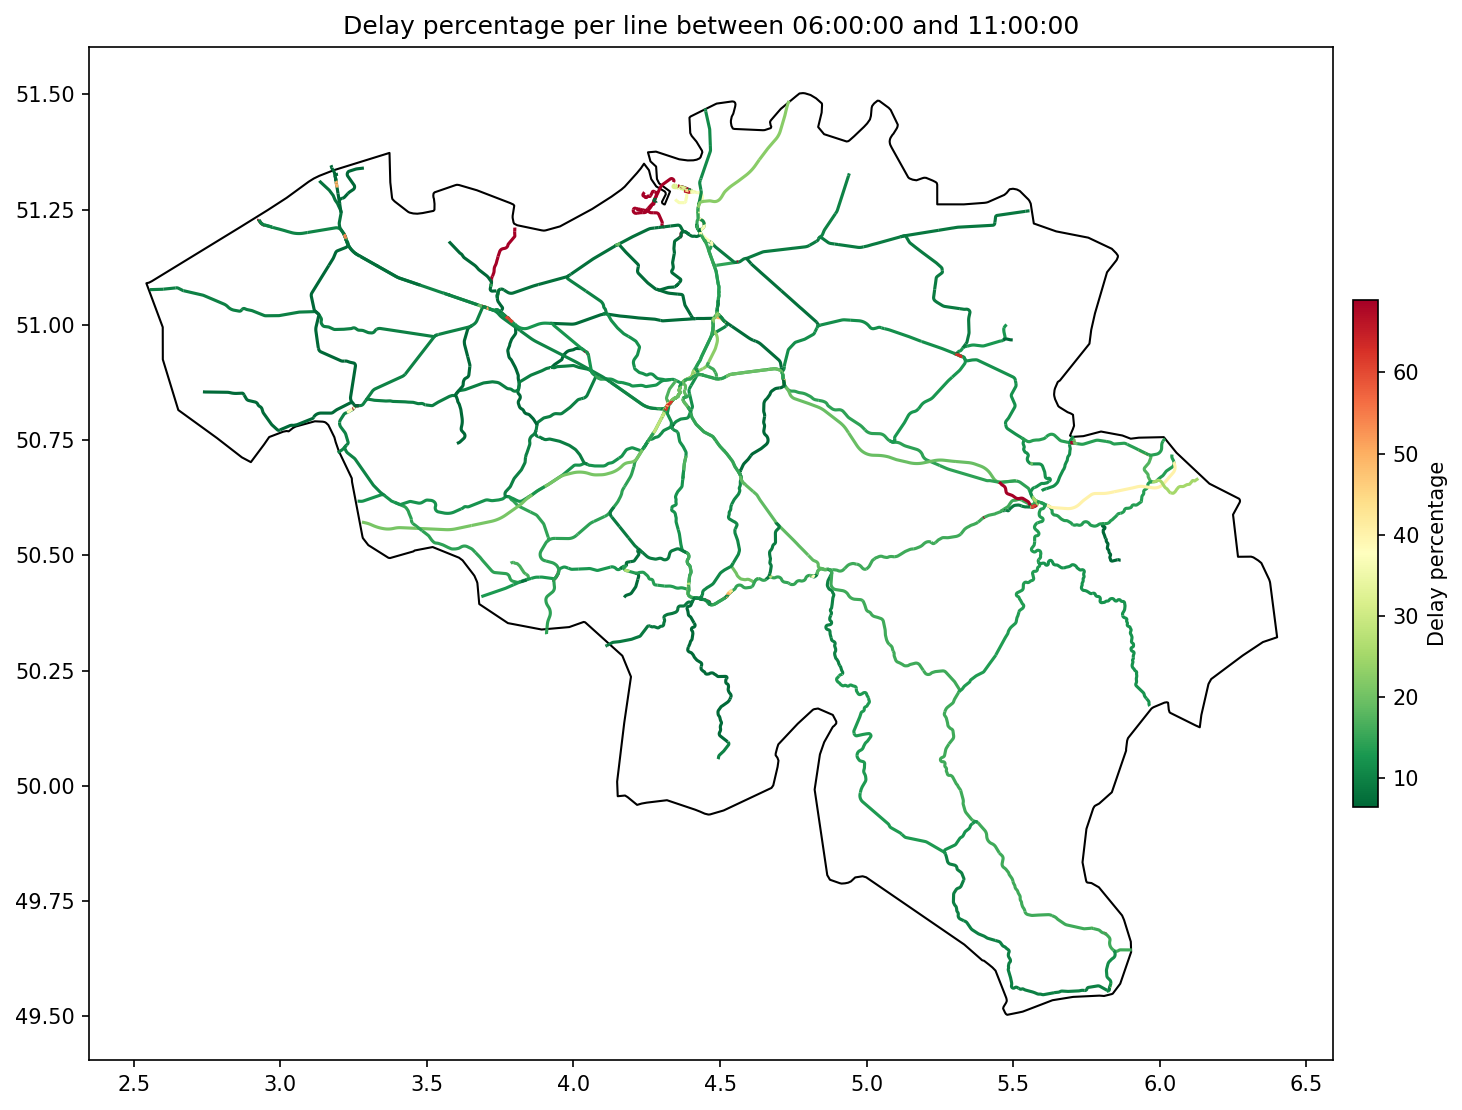

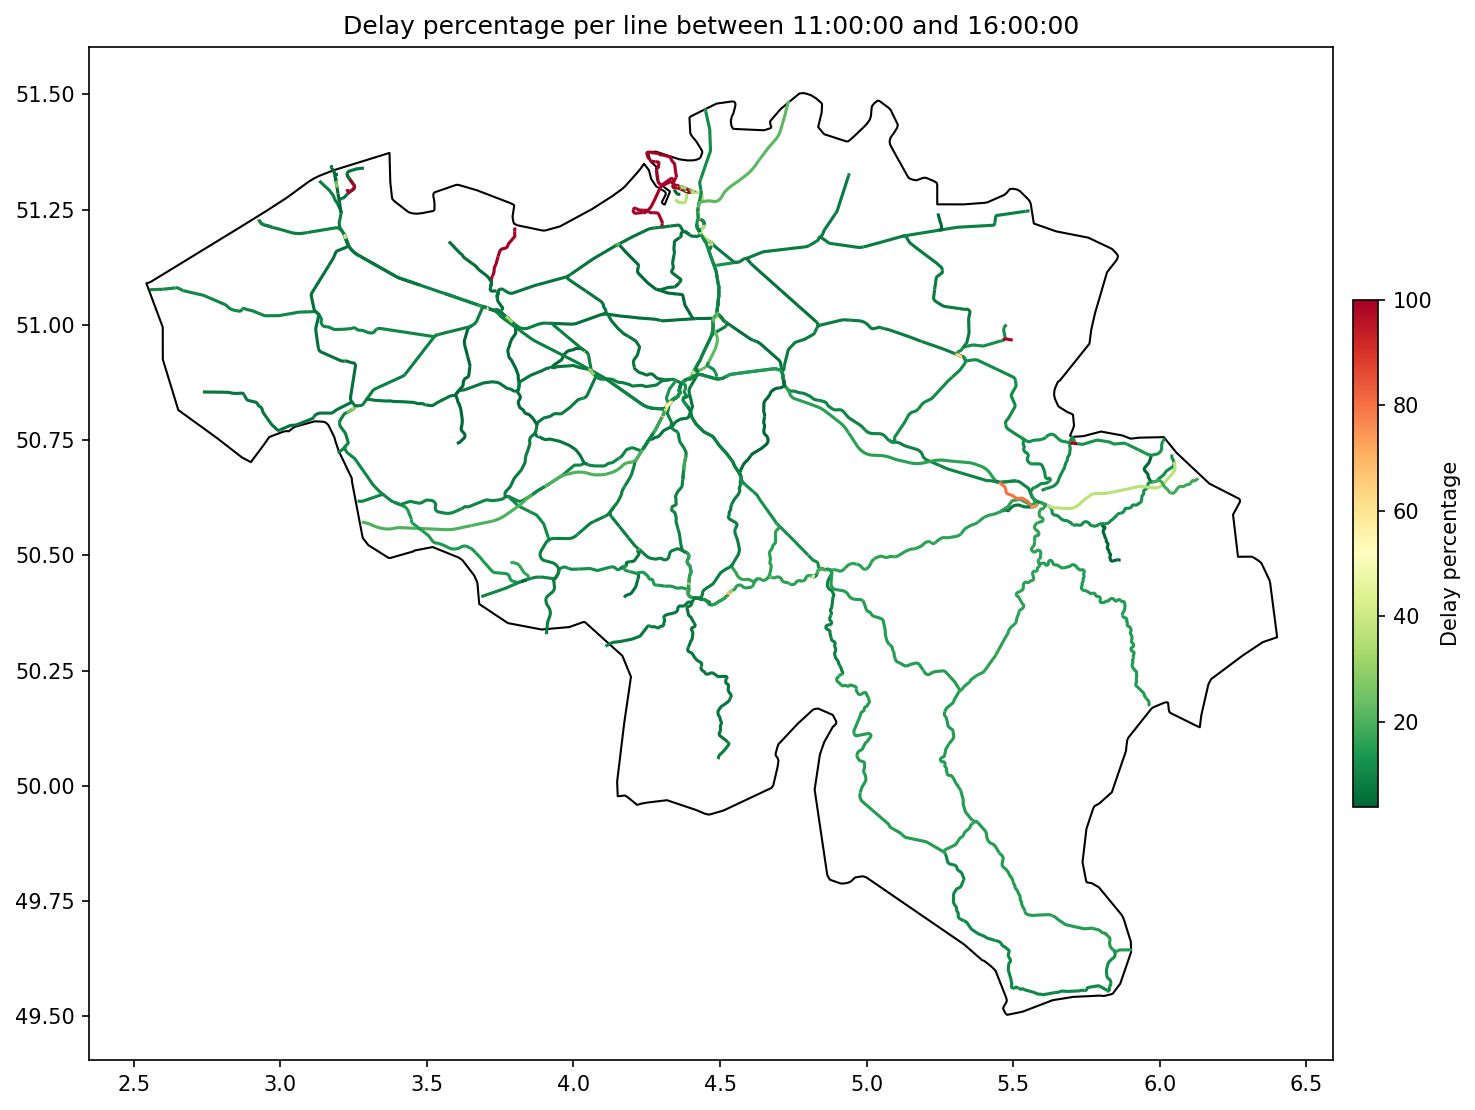

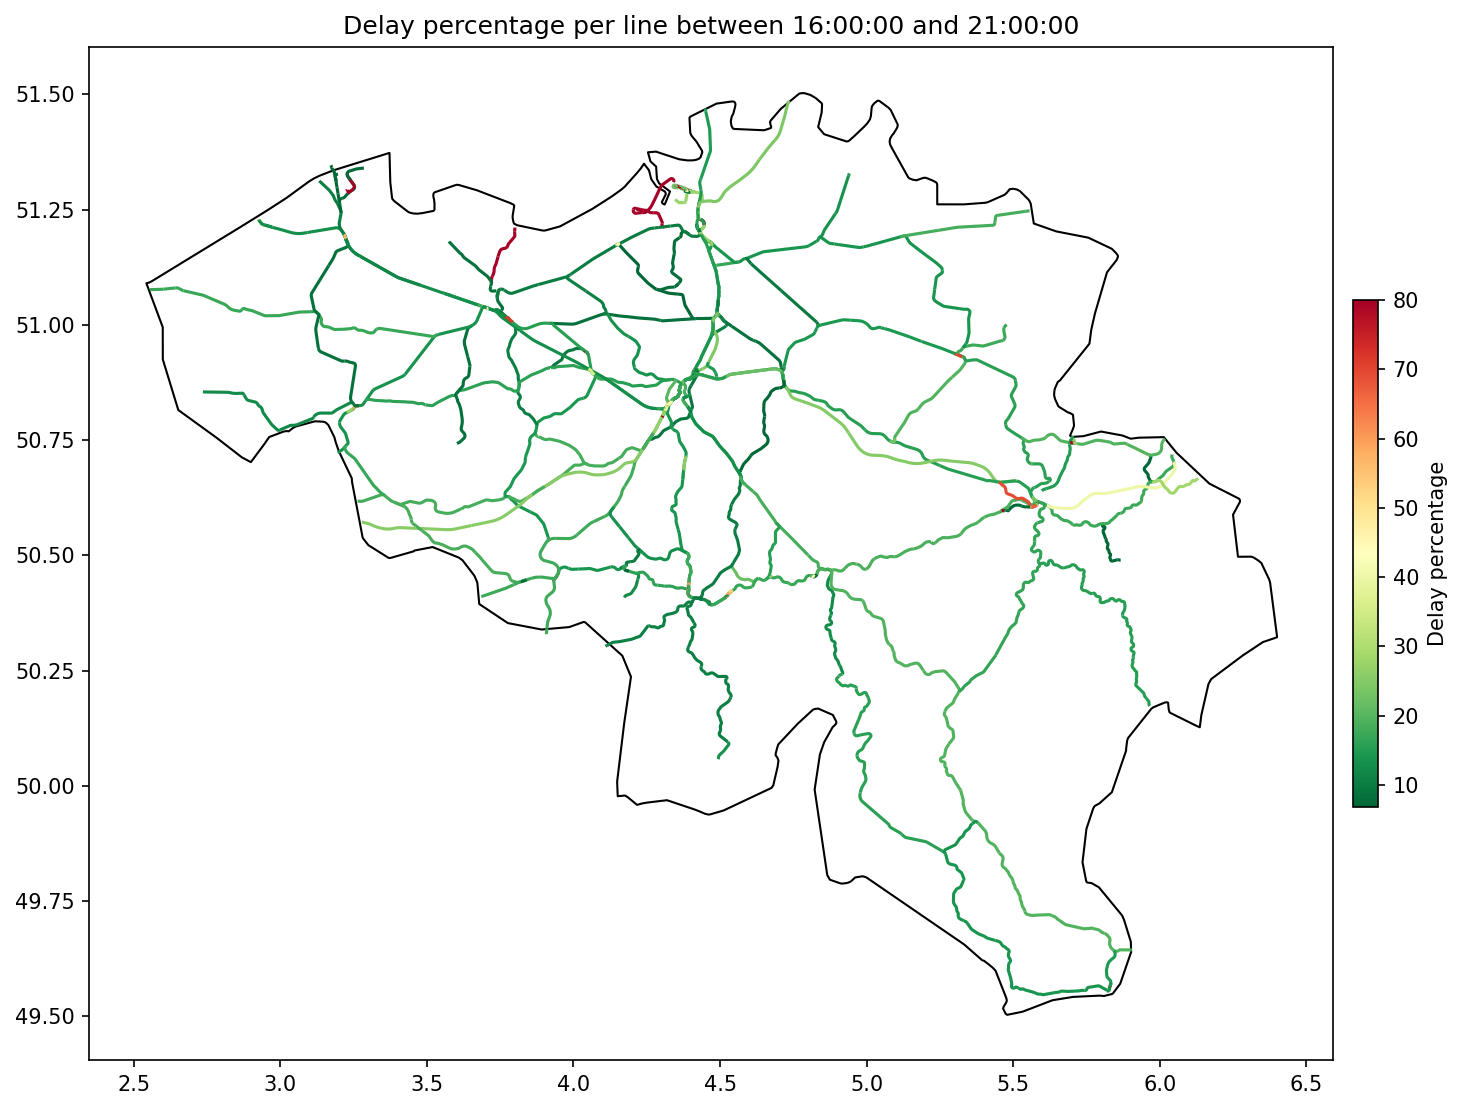

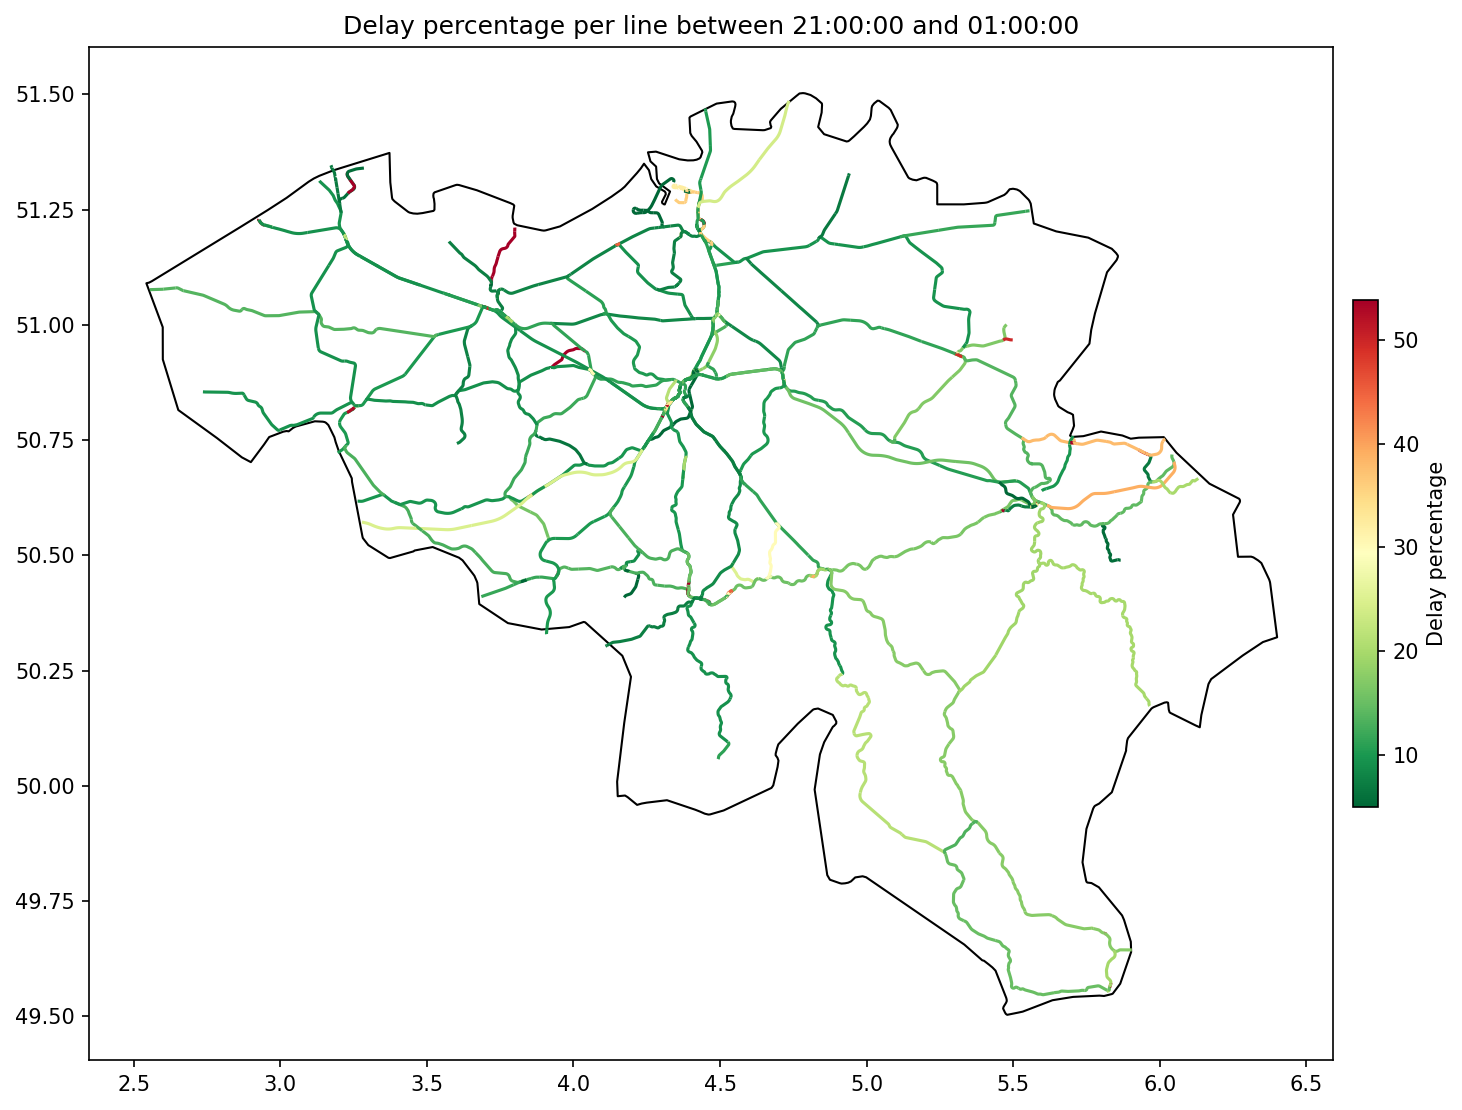

In [13]:
range_time = [("06:00:00", "11:00:00"), ("11:00:00", "16:00:00"), ("16:00:00", "21:00:00"), ("21:00:00", "01:00:00")]

where_clause = ["td.planned_time_arrival"]

for start, end in range_time:
    Query = f"""
        WITH delay_counts AS (
            SELECT
                line_number_departure,
                COUNT(*) as TOTAL_COUNT,
                SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) AS delayed_count,
                (SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS delay_percentage
            FROM
                train_data td
            JOIN
                type_day h on h.date = td.departure_date
            WHERE
                {'(td.planned_time_arrival BETWEEN \'' + start + '\' AND \'' + end + '\')' if start < end else 
                '(td.planned_time_arrival >= \'' + start + '\' OR td.planned_time_arrival <= \'' + end + '\')'}
            GROUP BY
                line_number_departure
        )
        SELECT
            cd.line_number_departure,
            cd.delay_percentage,
            r.geom
        FROM
            delay_counts cd
        JOIN
            railway r ON cd.line_number_departure = r.line_number
    """

    delay_percentage = gpd.read_postgis(Query, engine)

    fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
    vmin, vmax = delay_percentage['delay_percentage'].quantile(0.05), delay_percentage['delay_percentage'].quantile(0.95)
    norm = Normalize(vmin=vmin, vmax=vmax)
    delay_percentage.plot(ax=ax, column='delay_percentage', legend=True, cmap='RdYlGn_r',     legend_kwds={
            'label': "Delay percentage",
            'shrink': 0.5,   # Reduce the size of the legend bar
            'aspect': 20,     # Make the legend bar thinner
            'pad': 0.01       # Reduce gap between plot and legend
        }, vmin=vmin, vmax=vmax)
    belgium.plot(ax=ax, edgecolor='black', facecolor="white", linewidth=1)
    plt.title(f"Delay percentage per line between {start} and {end}")
    plt.tight_layout()
    plt.show()    